In [1]:
from scipy.io import loadmat, savemat
from scipy.linalg import orth
import numpy as np
import faiss
from scipy.spatial.distance import cdist
import pandas as pd

from tqdm import tqdm
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import gc
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'lib')))

from randn2 import randn2 
import peer_functions as peer

import math
from tqdm import tqdm
os.environ['OPENBLAS_NUM_THREADS'] = '1'

from datasets import ExperimentRunner


c:\Users\21361535\AppData\Local\anaconda3\envs\lava3\lib\site-packages\lava\utils\profiler.py:16: UserWarning: Loihi2HWProfiler could not be imported. Currently no profiler is available.
  warnings.warn("Loihi2HWProfiler could not be imported. "


In [2]:
def calculate_evaluation_metrics(similarity_matrix, ground_truth):
    """
    Calculate evaluation metrics for place recognition results
    
    Args:
        similarity_matrix: Matrix of similarity scores between queries and database
        ground_truth: Ground truth data containing GThard and GTsoft
        
    Returns:
        dict: Dictionary containing recalls, precision, recall curves and AUC
    """
    # Get candidate selections
    ids_pos = peer.directCandSel(similarity_matrix)
    
    # Calculate recall values
    recalls = peer.getRecallAtKVector(ids_pos, ground_truth["GT"])
    
    # Calculate precision-recall curves and AUC
    [R, P] = peer.createPR(-similarity_matrix, 
                          ground_truth['GT']["GThard"][0][0], 
                          ground_truth['GT']["GTsoft"][0][0])
    auc = np.trapz(P, R)
    
    return {
        'recalls': recalls,
        'precision': P,
        'recall': R,
        'auc': auc
    }



In [3]:
D1    = loadmat("../datasets/descriptors/GardensPointWalking/day_left/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']
D2    = loadmat("../datasets/descriptors/GardensPointWalking/night_right/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']


g_truth = loadmat("../datasets/ground_truth/GardensPointWalking/day_left--night_right/gt.mat")

# Calculate the average vector for D1
average_vector = np.mean(D1, axis=0)

# Replace the first vector in D1 with the average vector
D1[0] = average_vector

# D1    = loadmat("../datasets/descriptors/CMU/20110421/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']
# D2    = loadmat("../datasets/descriptors/CMU/20100901/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']

# g_truth = loadmat("../datasets/ground_truth/CMU/20110421--20100901/gt.mat")


# D1    = loadmat("../datasets/descriptors/Nordland1000/spring/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']
# D2    = loadmat("../datasets/descriptors/Nordland1000/winter/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']

# g_truth = loadmat("../datasets/ground_truth/Nordland1000/spring--winter/gt.mat")


In [4]:
from dot_product import  LoihiDotProductSimulationPositive, LoihiDotProductSimulationPositive3Layer, LoihiDotProductSimulationPositiveDBScale


## SNN 2 Layer

In [5]:
constant = 1/math.sqrt(2)

dot = LoihiDotProductSimulationPositiveDBScale(D1, D2, constant, timesteps=16, dbScale=6*3)


In [6]:
# DD, qs, dbs = dot.run()

qs, dbs, monitors = dot.run(monitor=True, customTimesteps=10)

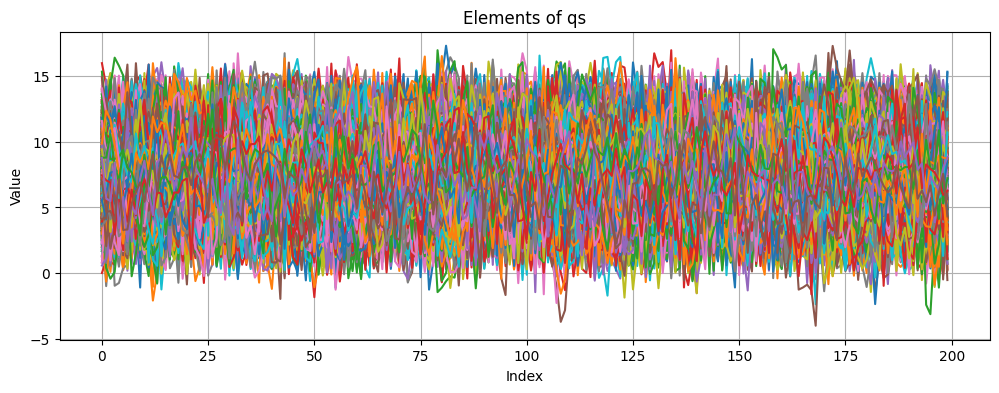

In [7]:
plt.figure(figsize=(12, 4))
plt.plot(qs)
# plt.plot(qs[1], '-')
# plt.plot(qs[2], '-')
plt.title('Elements of qs')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

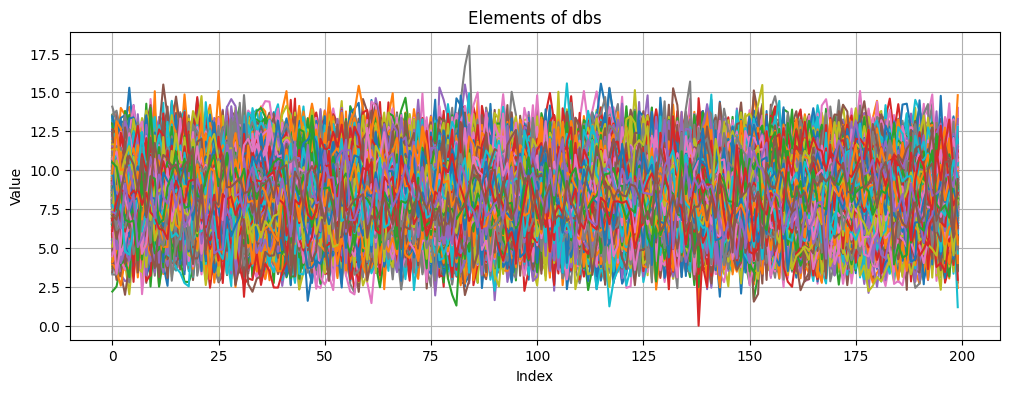

In [8]:
plt.figure(figsize=(12, 4))
plt.plot(dbs)
# plt.plot(qs[1], '-')
# plt.plot(qs[2], '-')
plt.title('Elements of dbs')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

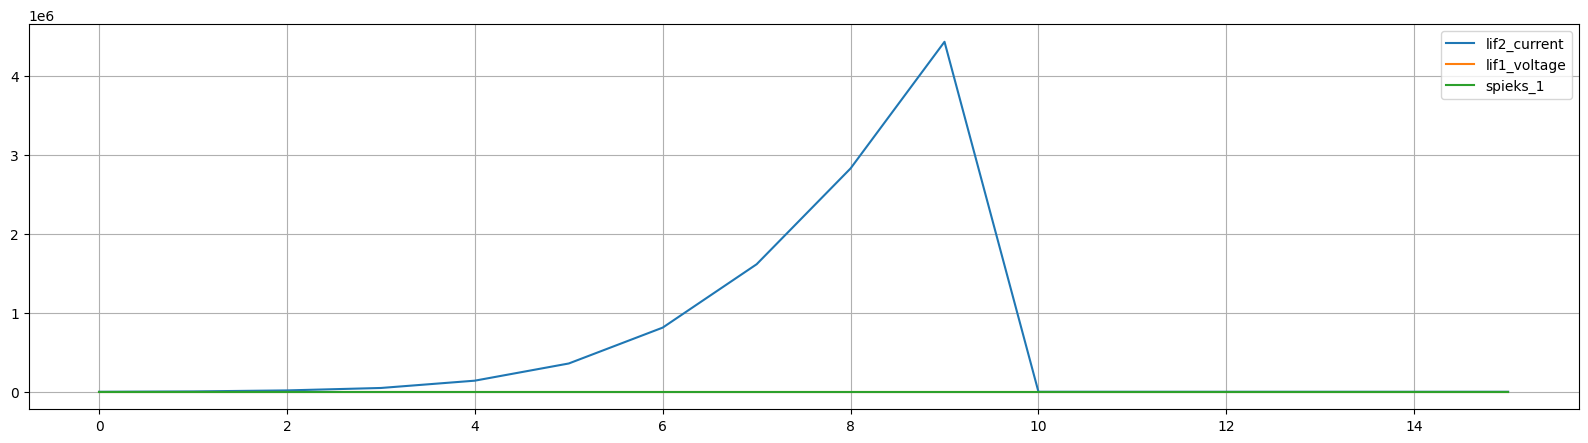

In [9]:
n_id = 38
plt.figure(figsize=(20, 5))
plt.plot(monitors['lif2_current'][:,n_id], label='lif2_current')
plt.plot(monitors['lif1_voltage'][:,n_id], label='lif1_voltage')
plt.plot(monitors['lif1_spikes'][:,n_id] * (10**6), label='spieks_1')
# plt.axhline(y=-(2**16 - 1)*2**6, color='r', linestyle='--', label='vth_lif_2')  # Changed to horizontal line
plt.grid(True)


plt.legend()
plt.show()


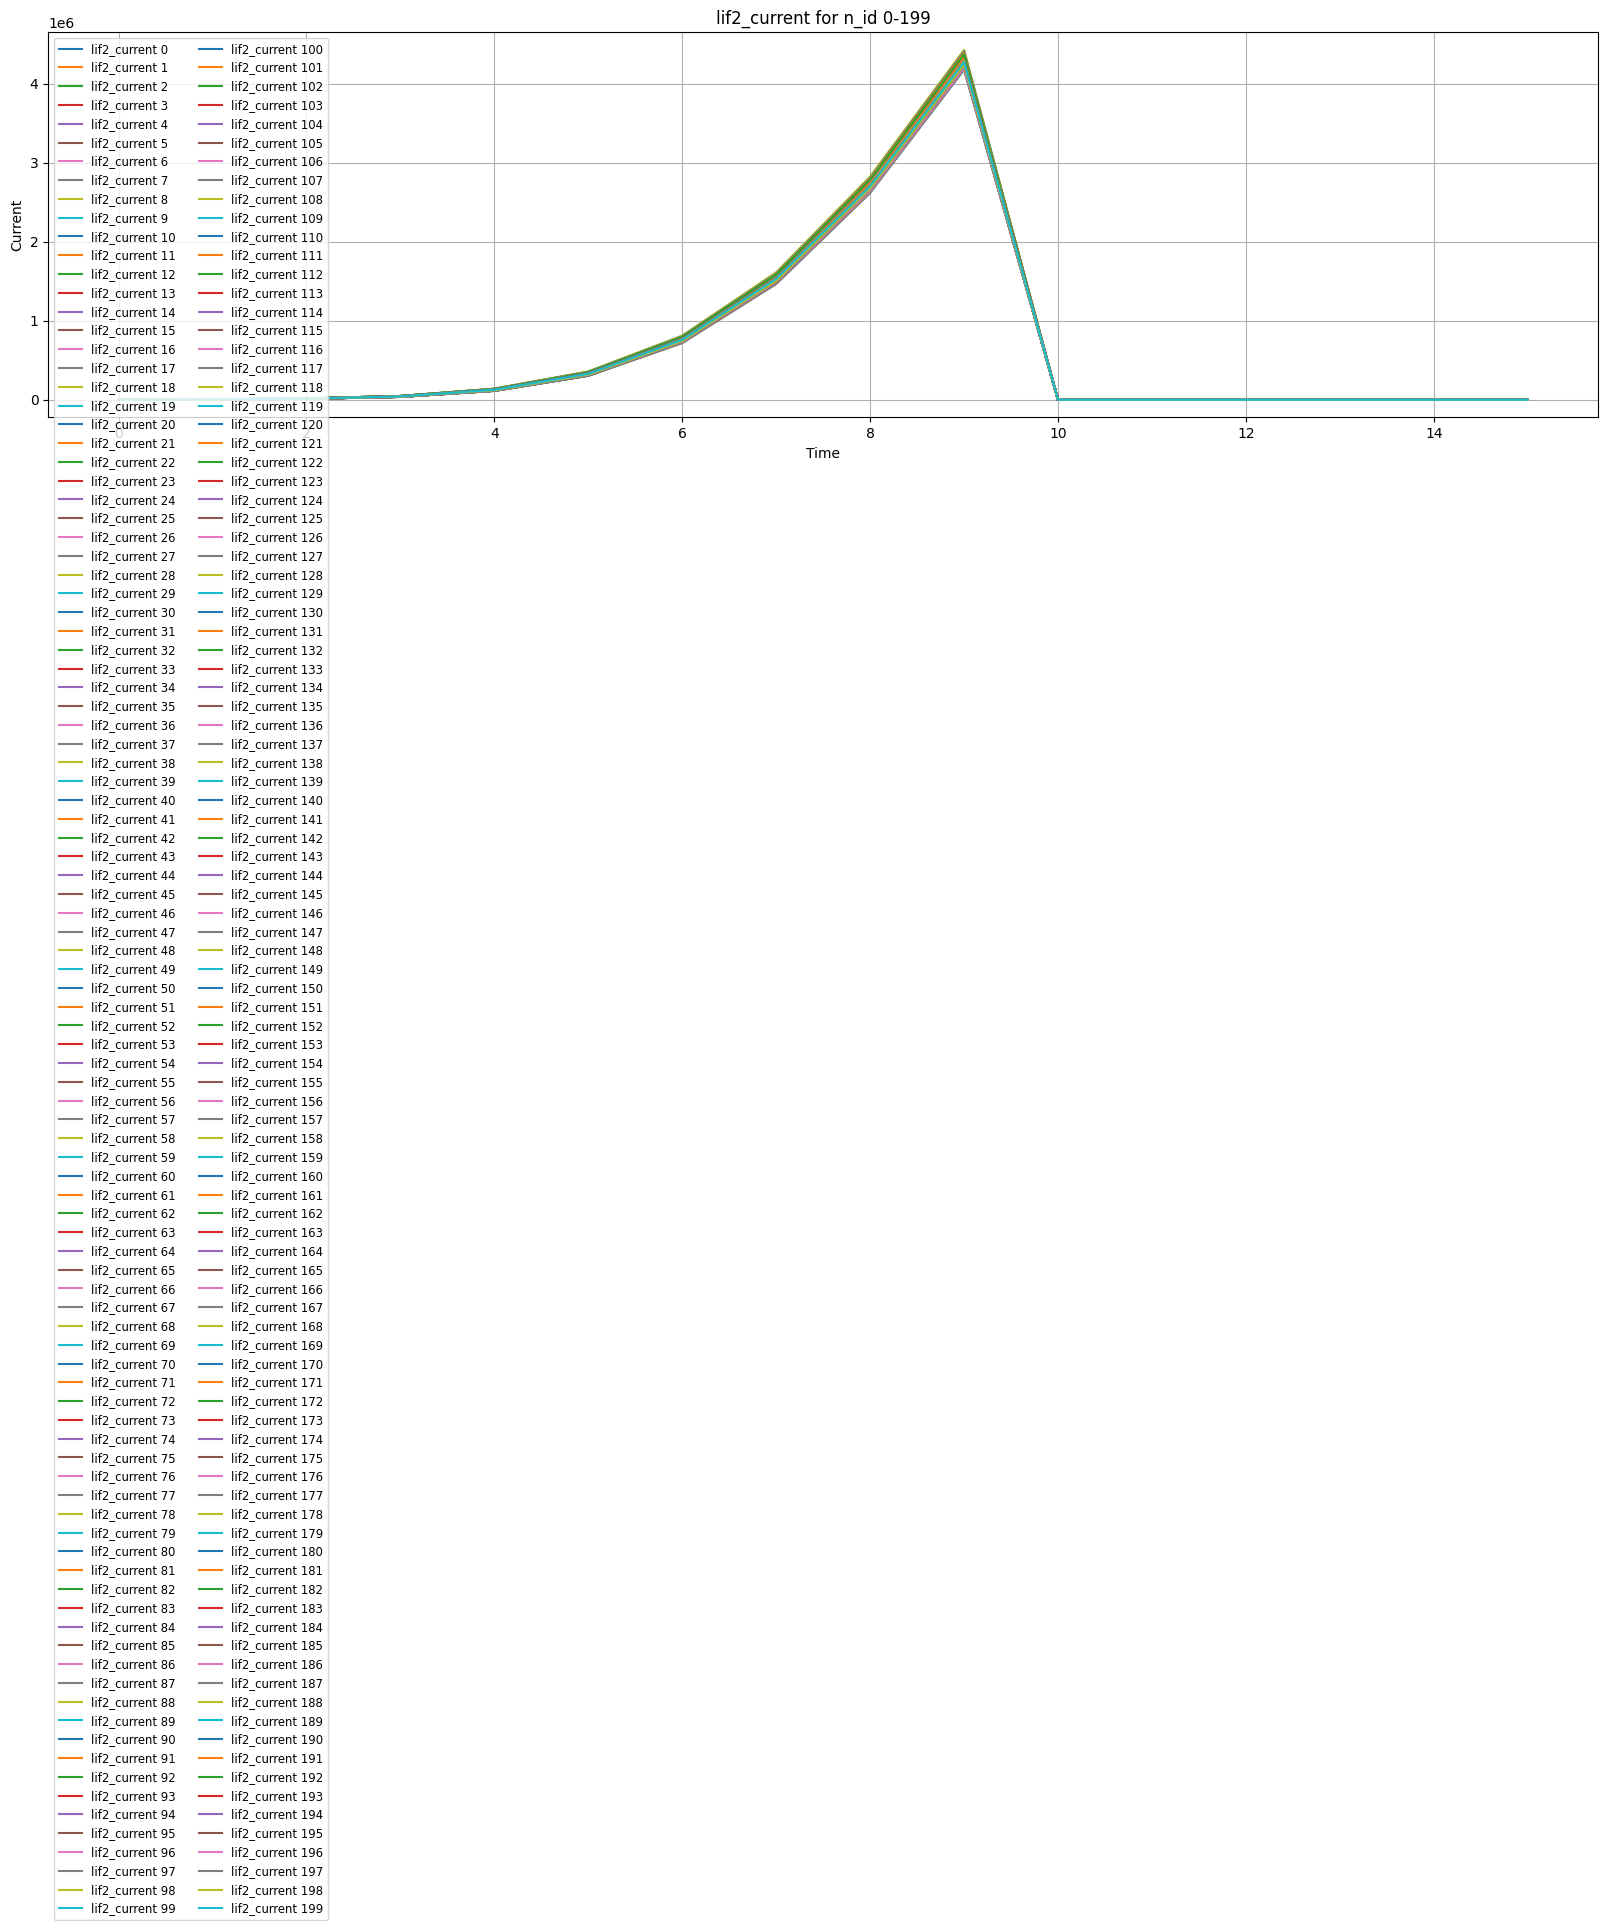

In [10]:
n_ids = range(200)  # Define the range for n_id
plt.figure(figsize=(20, 5))

for n_id in n_ids:
    plt.plot(monitors['lif2_current'][:, n_id], label=f'lif2_current {n_id}')

plt.title('lif2_current for n_id 0-199')
plt.xlabel('Time')
plt.ylabel('Current')
plt.grid(True)
plt.legend(loc='upper left', ncol=2, fontsize='small')  # Adjust legend to fit all labels
plt.show()

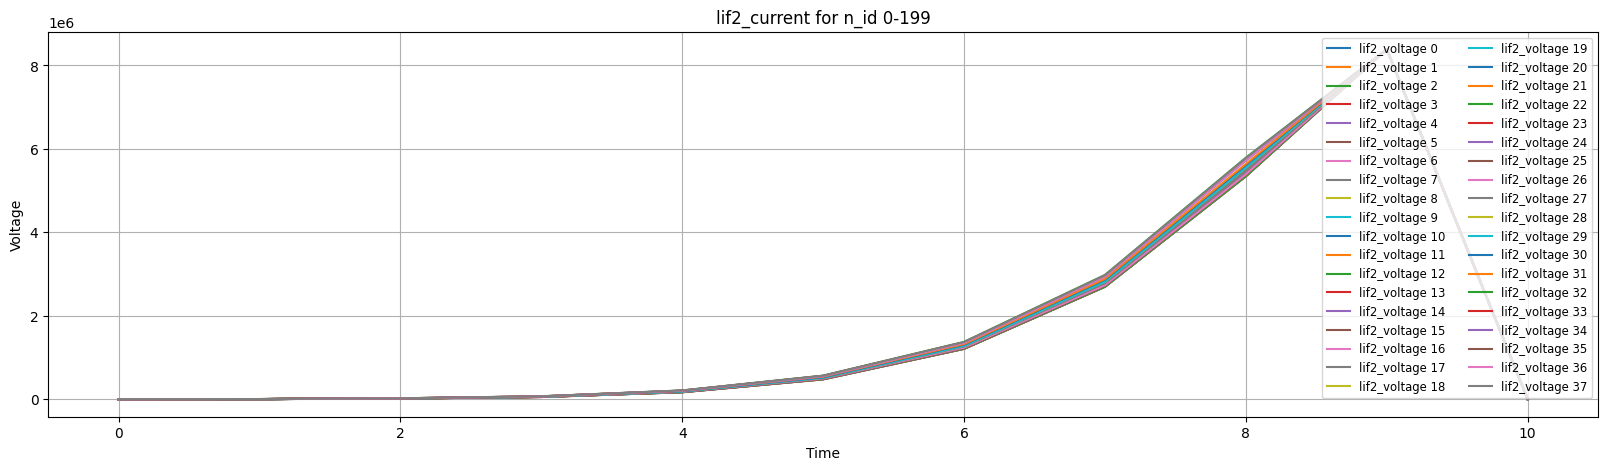

In [11]:
n_ids = range(38)  # Define the range for n_id
plt.figure(figsize=(20, 5))

for n_id in n_ids:
    plt.plot(monitors['lif2_voltage'][:, n_id][:11], label=f'lif2_voltage {n_id}')

plt.title('lif2_current for n_id 0-199')
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.grid(True)
plt.legend(loc='upper right', ncol=2, fontsize='small')  # Adjust legend to fit all labels
plt.show()

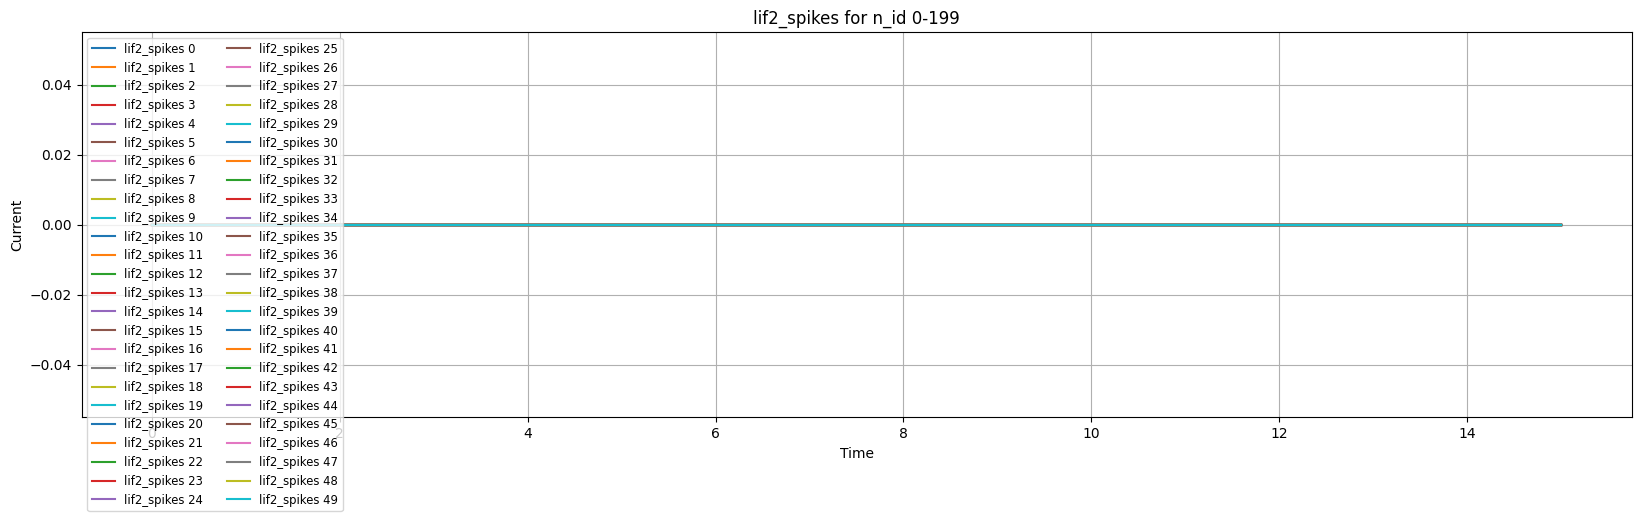

In [12]:
n_ids = range(50)  # Define the range for n_id
plt.figure(figsize=(20, 5))

for n_id in n_ids:
    plt.plot(monitors['lif2_spikes'][:, n_id], label=f'lif2_spikes {n_id}')

plt.title('lif2_spikes for n_id 0-199')
plt.xlabel('Time')
plt.ylabel('Current')
plt.grid(True)
plt.legend(loc='upper left', ncol=2, fontsize='small')  # Adjust legend to fit all labels
plt.show()

In [13]:
max = -1
max_id = -1
final_voltages = []
for n_id in range(0,200):
    val = monitors['lif2_current'][:, n_id][9]
    final_voltages.append(val)
    if val > max:
        max = val
        max_id = n_id

4428527.0 38


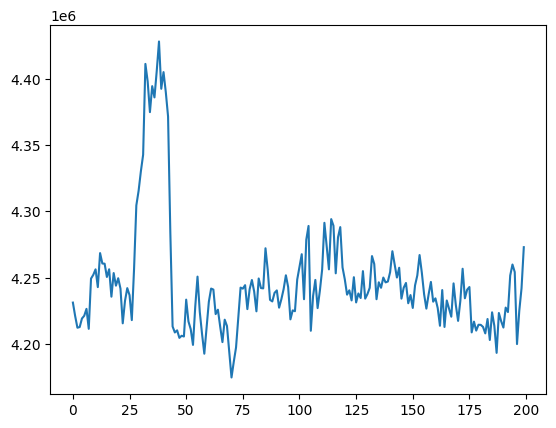

In [14]:
print(max, max_id)
plt.plot(final_voltages, label = "final current")

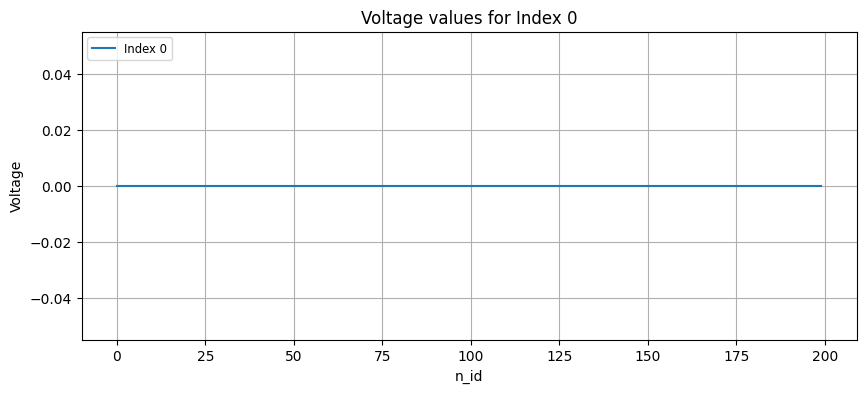

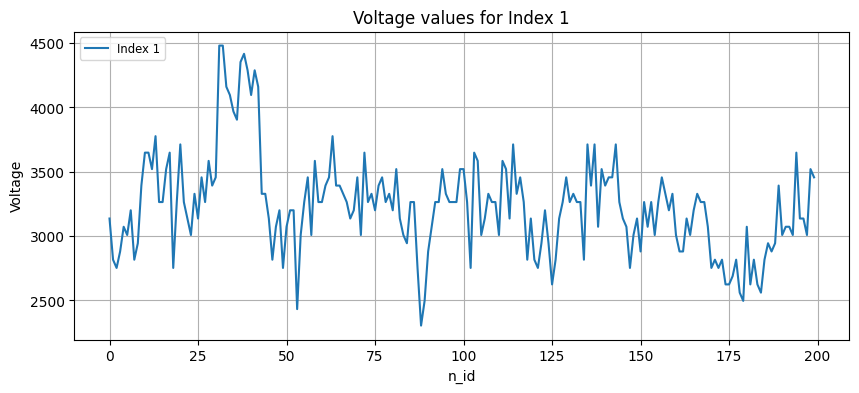

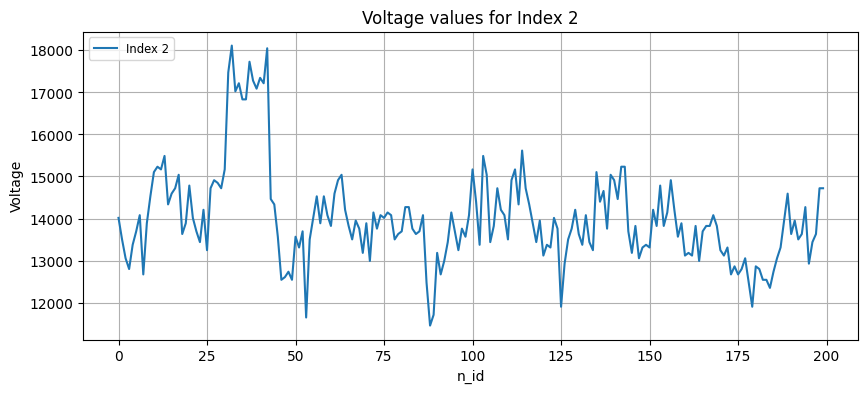

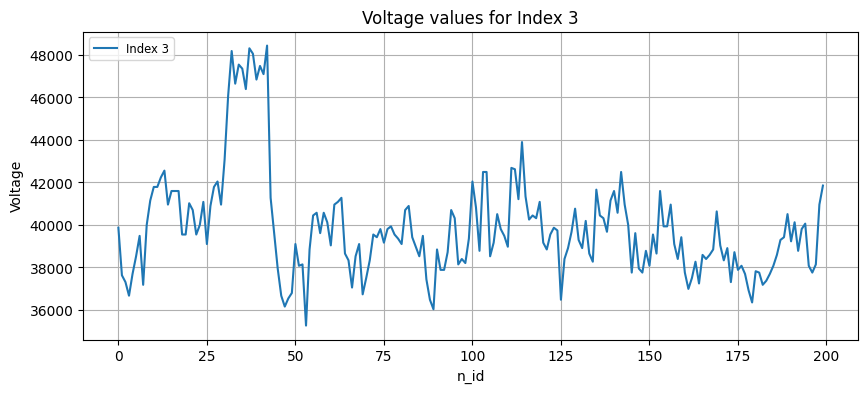

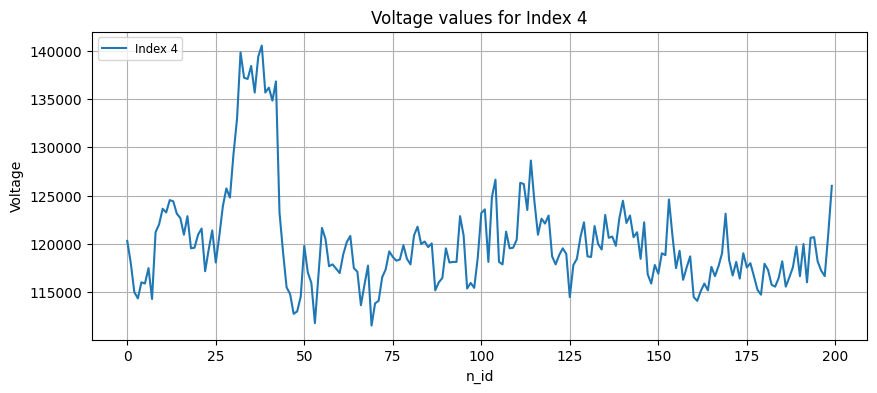

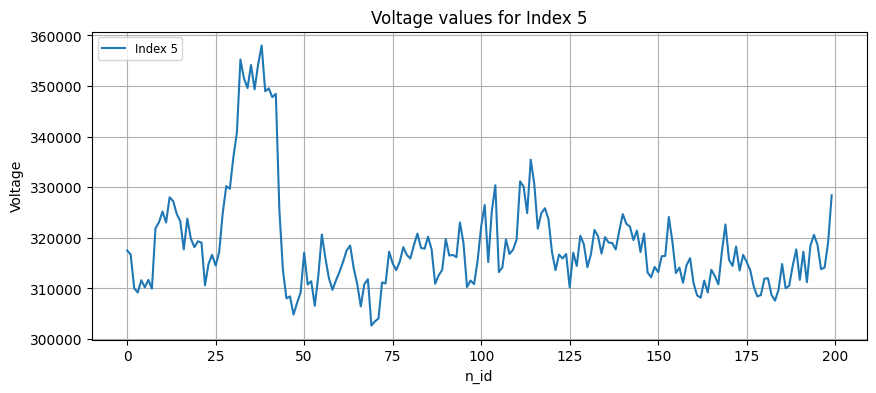

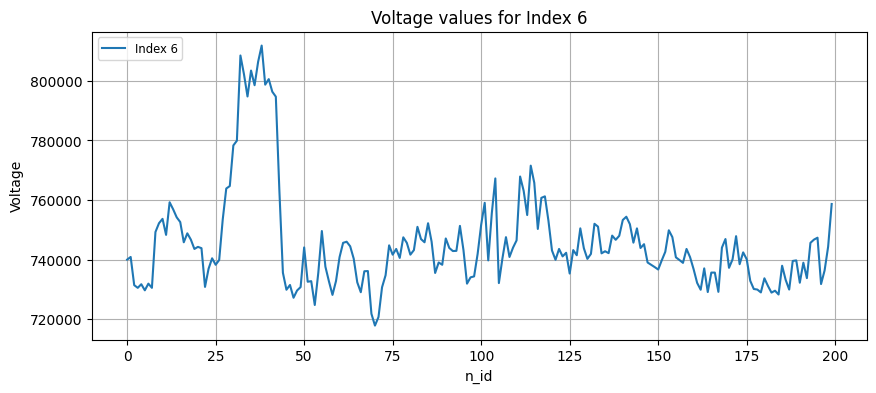

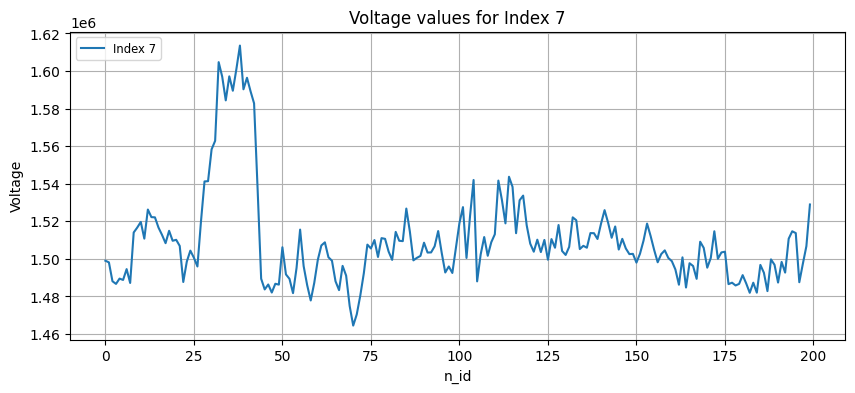

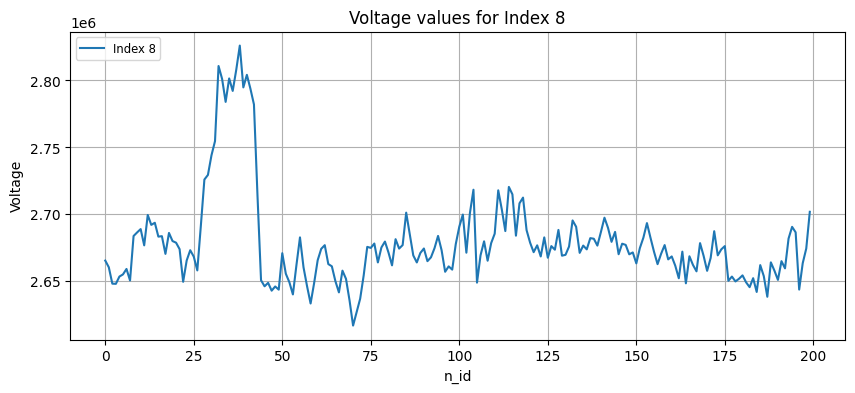

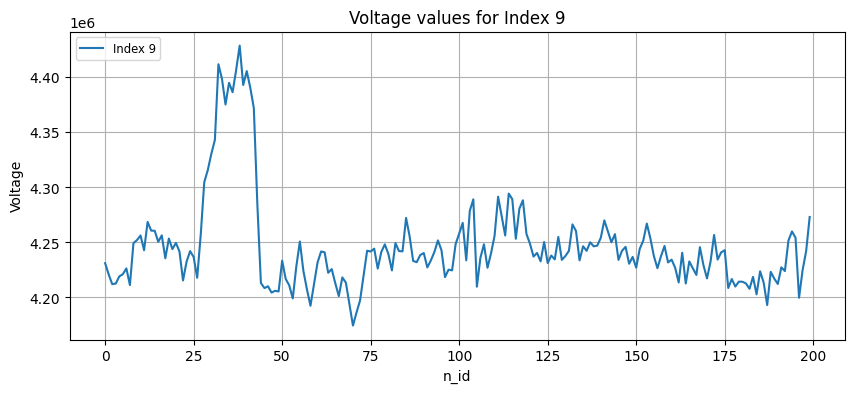

In [15]:


# Initialize a dictionary to store values for each index
voltage_dict = {i: [] for i in range(10)}

max = -1
max_id = -1
final_voltages = []

for n_id in range(0, 200):
    # Append values from indices 0 to 9 to the dictionary
    for i in range(10):
        val = monitors['lif2_current'][:, n_id][i]
        voltage_dict[i].append(val)
    
    # Append the value at index 1 to final_voltages
    val = monitors['lif2_current'][:, n_id][1]
    final_voltages.append(val)
    
    if val > max:
        max = val
        max_id = n_id

# Plot the values from the dictionary in separate plots
for i in range(10):
    plt.figure(figsize=(10, 4))
    plt.plot(voltage_dict[i], label=f'Index {i}')
    plt.title(f'Voltage values for Index {i}')
    plt.xlabel('n_id')
    plt.ylabel('Voltage')
    plt.grid(True)
    plt.legend(loc='upper left', fontsize='small')
    plt.show()



4480.0 31


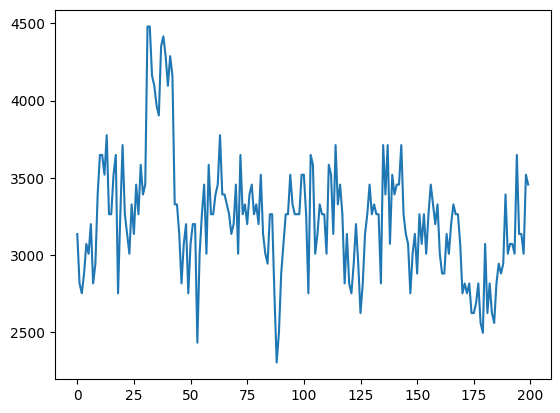

In [16]:
print(max, max_id)
plt.plot(final_voltages)

In [17]:
print(monitors['lif2_current'][:,38])#, label='lif2_current')

[0.000000e+00 4.416000e+03 1.727800e+04 4.805700e+04 1.405250e+05 3.579620e+05 8.118260e+05 1.613547e+06
 2.826081e+06 4.428527e+06 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]


In [18]:
DD = dot.run(D1, D2, monitor=False, customTimesteps=10)

100%|██████████| 200/200 [00:35<00:00,  5.57it/s]


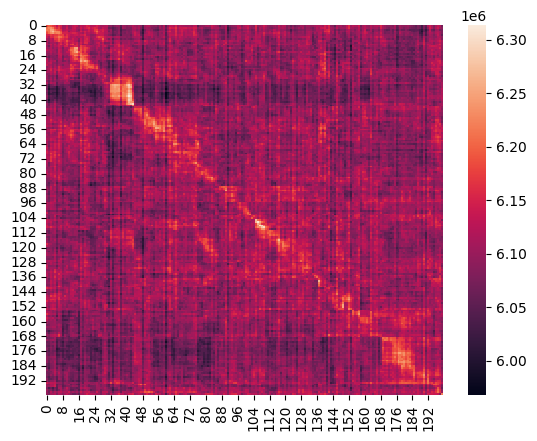

In [19]:
import seaborn as sns

ax = sns.heatmap(DD)
plt.show()

In [20]:

metrics = calculate_evaluation_metrics(-DD, g_truth)
print(f"AUC: {metrics['auc']}")


AUC: 0.4085876186106758


In [ ]:
AUC: 0.4119300004977293

In [18]:
# Find the maximum value in the DD matrix
max_value = np.max(DD)

# Find the indices of the maximum value
max_indices = np.unravel_index(np.argmax(DD), DD.shape)

print(f"Maximum value: {max_value}")
print(f"Indices of maximum value: {max_indices}")

Maximum value: 2583090.0
Indices of maximum value: (38, 41)


## Results

In [21]:
# Compute dot product between all pairs of vectors
dot_product_matrix = np.dot(dbs, qs.T)  # This will give a 200x200 matrix

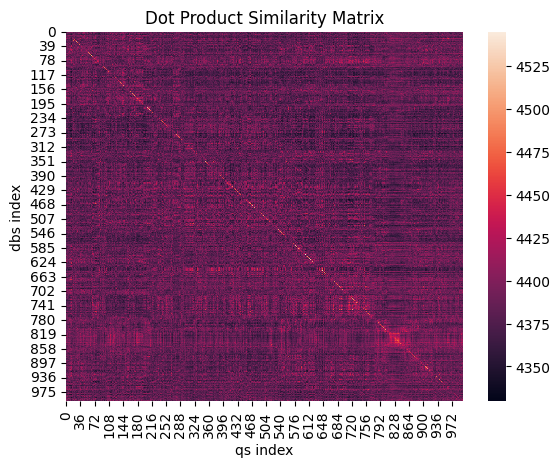

In [22]:
import seaborn as sns

ax = sns.heatmap(dot_product_matrix/2**6)
plt.title('Dot Product Similarity Matrix')
plt.ylabel('dbs index')
plt.xlabel('qs index')
plt.show()

In [17]:
metrics = calculate_evaluation_metrics(-dot_product_matrix, g_truth)
print(f"AUC: {metrics['auc']}")

AUC: 0.470304206812627


In [23]:
from dot_product import  CPUDotProduct

dot = CPUDotProduct(D1, D2)

In [24]:
DD_CPU = dot.run()

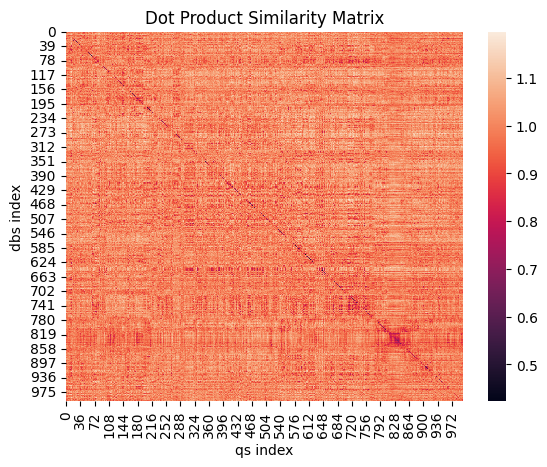

In [25]:
import seaborn as sns

ax = sns.heatmap(DD_CPU.T)
plt.title('Dot Product Similarity Matrix')
plt.ylabel('dbs index')
plt.xlabel('qs index')
plt.show()

In [22]:
metrics = calculate_evaluation_metrics(DD_CPU.T, g_truth)
print(f"AUC: {metrics['auc']}")

AUC: 0.4702147082864312


In [29]:
0.406751268123599
0.406751268123599
0.406751268123599
0.41105831265952125 # Dense layer multiplied by 10 not timesteps (signs of overflow) -2,000
0.022280486025402297 # Dense layer multiplier changed to 1
0.4147533173640495 # Dense layer multiplied by 20 (signs of overflow) -10,000
# ============================================ Upto this, the constant is 0
0.005699984139190401 # Constant changed to 1/sqrt(2)
0.29100275201856207 # Constant changed to 0 while the vector transformation is done as per positive cpu experiment
0.4528012779410795
0.45785226214439223
0.4634606913087941

0.4634606913087941

In [30]:
hrd =   g_truth['GT']["GThard"][0][0]


In [31]:
sft =   g_truth['GT']["GTsoft"][0][0]

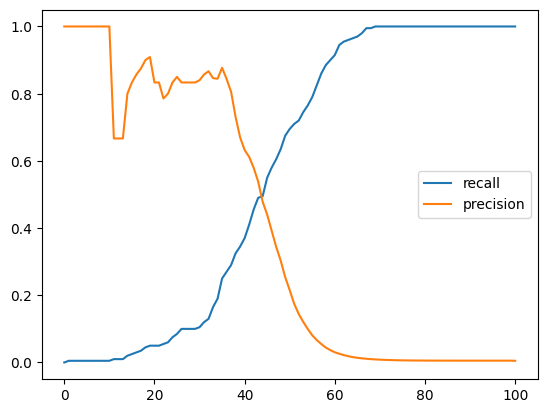

In [32]:
plt.plot(metrics['recall'], label='recall')
plt.plot(metrics['precision'], label='precision')
plt.legend()


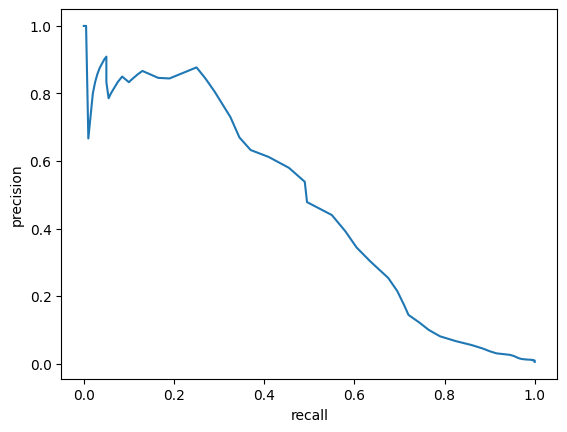

In [33]:

# plt.plot(metrics['precision'], metrics['recall'])
plt.plot(metrics['recall'], metrics['precision'])
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

